In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("C://Users//ADMIN//Desktop//datasets//synthetic_road_accidents_100k.csv")
display(df.head())

display("Description Analysis:\n", df.describe())
display("\nInfo:")
print(df.info())


,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,rural,2,0.29,70,night,rainy,False,True,evening,False,False,1,0.64
1,highway,1,0.34,25,dim,clear,False,False,morning,False,False,3,0.27
2,rural,2,0.76,70,night,foggy,True,False,evening,True,True,1,0.76
3,rural,3,0.37,70,night,foggy,True,False,morning,False,True,0,0.60
4,highway,3,0.39,45,dim,rainy,False,True,morning,False,False,0,0.17


'Description Analysis:\n'

,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,2.495300,0.500619,47.054550,1.50308,0.382613
std,1.117958,0.288691,16.321527,1.22866,0.178692
min,1.000000,0.000000,25.000000,0.00000,0.000000
25%,1.000000,0.250000,35.000000,1.00000,0.250000
50%,2.000000,0.500000,45.000000,1.00000,0.380000
75%,3.000000,0.750000,60.000000,2.00000,0.510000
max,4.000000,1.000000,70.000000,10.00000,1.000000


'\nInfo:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               100000 non-null  object 
 1   num_lanes               100000 non-null  int64  
 2   curvature               100000 non-null  float64
 3   speed_limit             100000 non-null  int64  
 4   lighting                100000 non-null  object 
 5   weather                 100000 non-null  object 
 6   road_signs_present      100000 non-null  bool   
 7   public_road             100000 non-null  bool   
 8   time_of_day             100000 non-null  object 
 9   holiday                 100000 non-null  bool   
 10  school_season           100000 non-null  bool   
 11  num_reported_accidents  100000 non-null  int64  
 12  accident_risk           100000 non-null  float64
dtypes: bool(4), float64(2), int64(3), object(4)
memory usage: 7.2+ MB
None


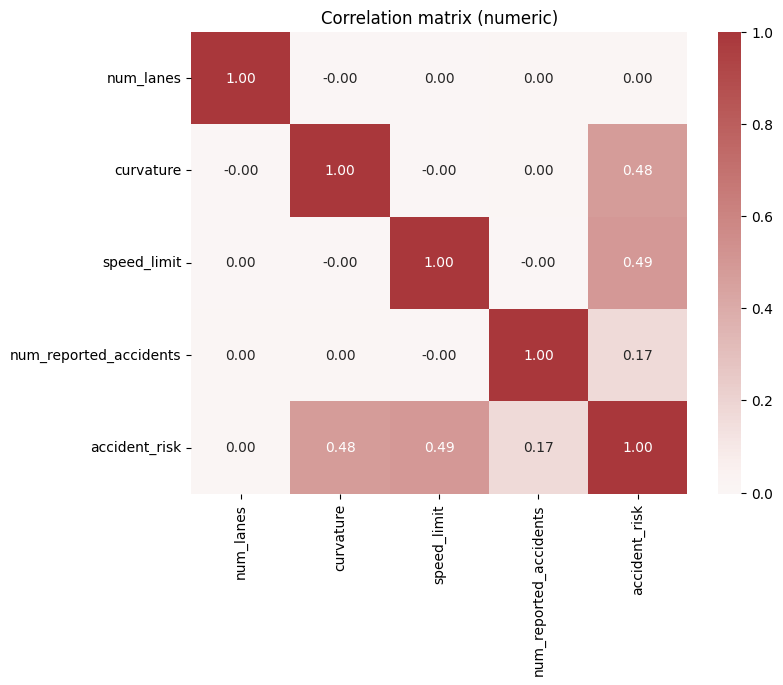


Top correlations with accident_risk:
accident_risk             1.000000
speed_limit               0.493560
curvature                 0.479614
num_reported_accidents    0.171228
num_lanes                 0.002335
Name: accident_risk, dtype: float64


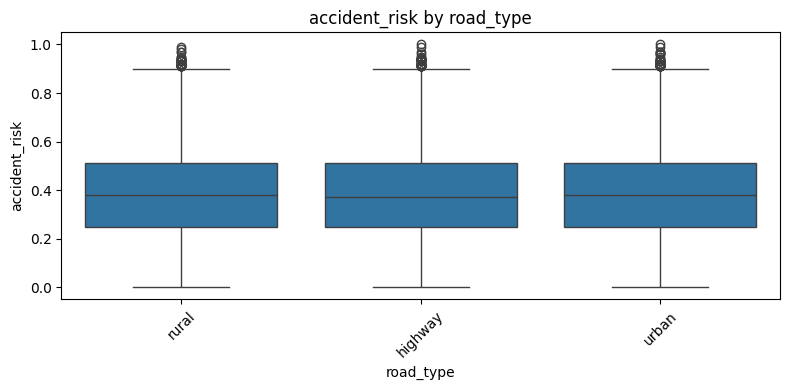

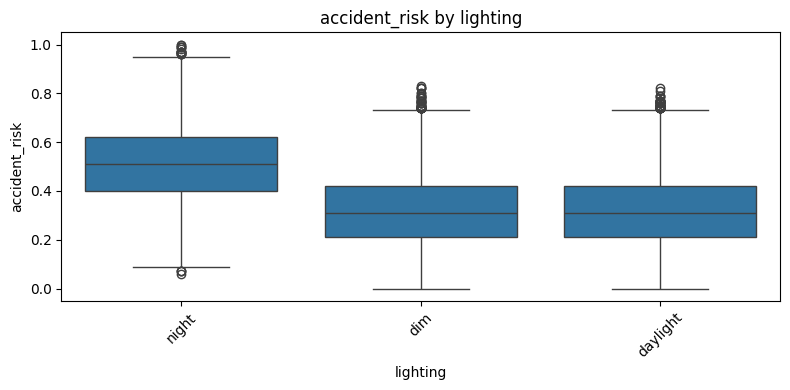

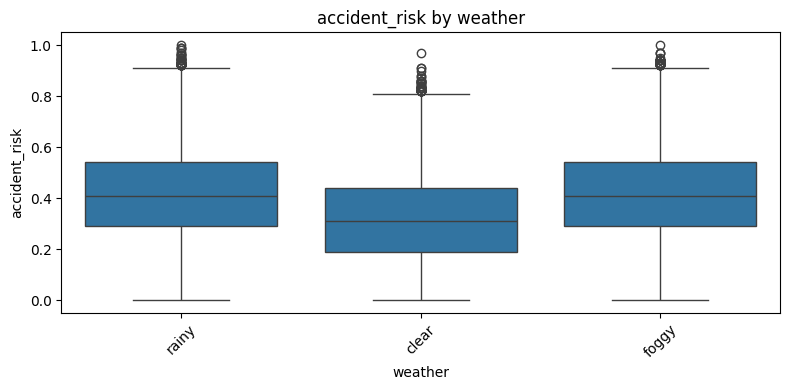

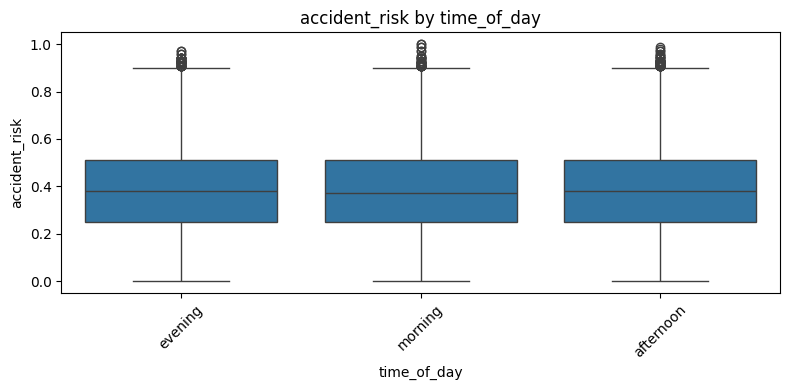

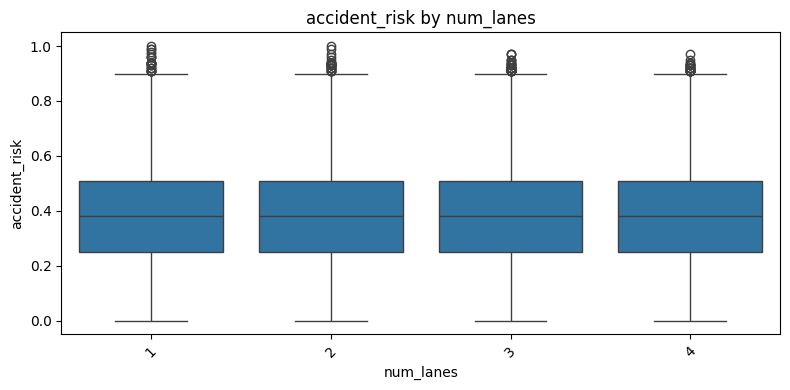

In [3]:
# General EDA for accident analysis dataset

# Determine numeric columns for correlation
num_cols = df.select_dtypes(include=['number']).columns.tolist()

# Correlation heatmap
corr = df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Correlation matrix (numeric)")
plt.show()

# Top correlations with target
print("\nTop correlations with accident_risk:")
print(corr['accident_risk'].abs().sort_values(ascending=False).head(10))

# Boxplots of accident_risk by selected categorical features
for col in ['road_type','lighting','weather','time_of_day','num_lanes']:
    if col in df.columns:
        plt.figure(figsize=(8,4))
        sns.boxplot(x=col, y='accident_risk', data=df)
        plt.title(f"accident_risk by {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()



In [4]:
# Convert boolean columns to integers (0 and 1) for Random Forest compatibility
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

print("\nData types after boolean conversion:")
print(df.dtypes)
print("\nProcessed DataFrame ready for Random Forest training:")
print(df.head())


Data types after boolean conversion:
road_type                  object
num_lanes                   int64
curvature                 float64
speed_limit                 int64
lighting                   object
weather                    object
road_signs_present          int64
public_road                 int64
time_of_day                object
holiday                     int64
school_season               int64
num_reported_accidents      int64
accident_risk             float64
dtype: object

Processed DataFrame ready for Random Forest training:
  road_type  num_lanes  curvature  speed_limit lighting weather  \
0     rural          2       0.29           70    night   rainy   
1   highway          1       0.34           25      dim   clear   
2     rural          2       0.76           70    night   foggy   
3     rural          3       0.37           70    night   foggy   
4   highway          3       0.39           45      dim   rainy   

   road_signs_present  public_road time_of_day  

## Random Forest Model

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     15021
           1       0.87      0.86      0.86      4979

    accuracy                           0.93     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.93      0.93      0.93     20000


Confusion Matrix:
[[14396   625]
 [  712  4267]]

ROC-AUC Score: 0.9796
Train Accuracy: 0.9698
Test Accuracy: 0.9332

Top 10 Most Important Features:
                   feature  importance
3              speed_limit    0.276928
2                curvature    0.267329
4                 lighting    0.251453
5                  weather    0.069386
11  num_reported_accidents    0.058531
1                num_lanes    0.018276
0                road_type    0.013979
8              time_of_day    0.012991
9                  holiday    0.008115
10           school_season    0.008111


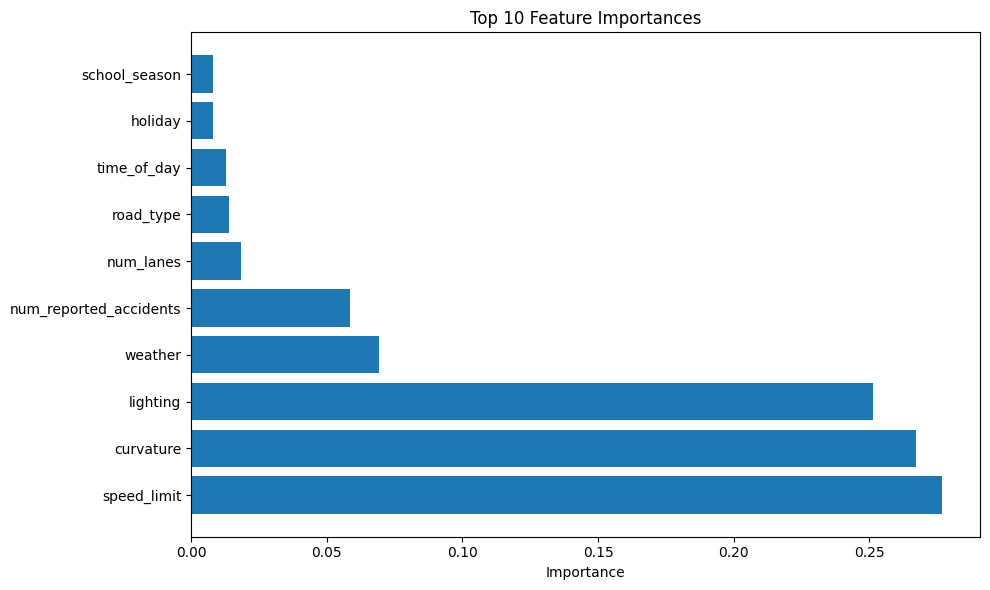

In [5]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Prepare processed_df (clean copy) and ensure target numeric
processed_df = df.copy()
processed_df['accident_risk'] = pd.to_numeric(processed_df['accident_risk'], errors='coerce')
if processed_df['accident_risk'].isnull().any():
    processed_df['accident_risk'].fillna(processed_df['accident_risk'].median(), inplace=True)

# Encode string/object categorical columns (reuse existing label_encoders if present)
cat_cols = processed_df.select_dtypes(include=['object','category']).columns.tolist()
if 'accident_risk' in cat_cols:
    cat_cols.remove('accident_risk')

try:
    label_encoders
except NameError:
    label_encoders = {}

for col in cat_cols:
    le = label_encoders.get(col, LabelEncoder())
    le.fit(processed_df[col].astype(str))
    label_encoders[col] = le
    processed_df[col] = le.transform(processed_df[col].astype(str))

# Prepare features and target (ensure numeric and no NaNs)
X = processed_df.drop('accident_risk', axis=1)
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
y = (processed_df['accident_risk'] > 0.5).astype(int)

# Split, train, evaluate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5, 
                                   min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Train Accuracy: {rf_model.score(X_train, y_train):.4f}")
print(f"Test Accuracy: {rf_model.score(X_test, y_test):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(10), feature_importance['importance'].head(10))
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()


Top categorical patterns (by predicted prob):


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4432\794164196.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  curv_stats = (analysis.groupby('curv_bin')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4432\794164196.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reports_stats = (analysis.groupby('reports_bin')
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4432\794164196.py:51: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_speed_curv = analy

,pattern,mean_pred_prob,mean_actual,count,lift
8,highway | night | rainy,0.601332,0.602883,763,2.389809
7,highway | night | foggy,0.593966,0.613540,709,2.360532
26,urban | night | rainy,0.586921,0.581232,714,2.332536
17,rural | night | rainy,0.585371,0.584637,703,2.326377
16,rural | night | foggy,0.582613,0.580163,736,2.315416
25,urban | night | foggy,0.573571,0.578804,736,2.279481
24,urban | night | clear,0.350550,0.347586,725,1.393153
6,highway | night | clear,0.345962,0.345946,740,1.374919
15,rural | night | clear,0.320629,0.305665,759,1.274241
23,urban | dim | rainy,0.194022,0.204929,771,0.771081



Curvature bin stats:


,curv_bin,mean_curvature,mean_pred_prob,mean_actual,count
0,"(0.0, 0.2]",0.103123,0.094567,0.078817,4022
1,"(0.2, 0.4]",0.306113,0.134585,0.129916,3941
2,"(0.4, 0.6]",0.504967,0.212186,0.212577,4055
3,"(0.6, 0.8]",0.704905,0.349415,0.350325,4002
4,"(0.8, 1.0]",0.901567,0.478376,0.484512,3874



Speed bin stats:


,speed_bin,mean_speed,mean_pred_prob,mean_actual,count
0,"(0, 30]",25.000000,0.105365,0.099699,3982
1,"(30, 45]",40.060667,0.101265,0.092644,7912
2,"(45, 55]",NaN,NaN,NaN,0
3,"(55, 65]",60.000000,0.470967,0.477261,4046
4,"(65, 75]",70.000000,0.469500,0.472414,4060
5,"(75, 200]",NaN,NaN,NaN,0



Reported-accidents bin stats:


,reports_bin,mean_reports,mean_pred_prob,mean_actual,count
0,"(-1, 0]",0.000000,0.220216,0.221351,4337
1,"(0, 1]",1.000000,0.218160,0.215548,6792
2,"(1, 2]",2.000000,0.219008,0.209677,4960
3,"(2, 3]",3.000000,0.387273,0.387008,2540
4,"(3, 5]",4.232213,0.379431,0.383112,1279
5,"(5, 999]",6.293478,0.439186,0.456522,92



Pivot: speed_bin x curv_bin (mean predicted_prob):


curv_bin,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
speed_bin,,,,,
"(0, 30]",0.016819,0.024996,0.074064,0.157554,0.255716
"(30, 45]",0.012742,0.028458,0.069023,0.159098,0.247357
"(55, 65]",0.212062,0.288355,0.429488,0.631331,0.794382
"(65, 75]",0.208983,0.302107,0.414038,0.641391,0.811555



High-risk segment summary (predicted_prob >= 0.8):


,road_type_label,lighting_label,weather_label,mean_pred_prob,mean_actual,count
17,rural,night,rainy,0.947239,0.960961,333
8,highway,night,rainy,0.944358,0.974790,357
16,rural,night,foggy,0.944108,0.970501,339
7,highway,night,foggy,0.941289,0.967930,343
25,urban,night,foggy,0.939035,0.956656,323
26,urban,night,rainy,0.936657,0.952381,336
24,urban,night,clear,0.933140,0.935065,154
15,rural,night,clear,0.932115,0.940397,151
6,highway,night,clear,0.926573,0.961111,180
19,urban,daylight,foggy,0.918815,0.921875,64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4432\794164196.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_patterns, x='mean_pred_prob', y='pattern', palette='magma')


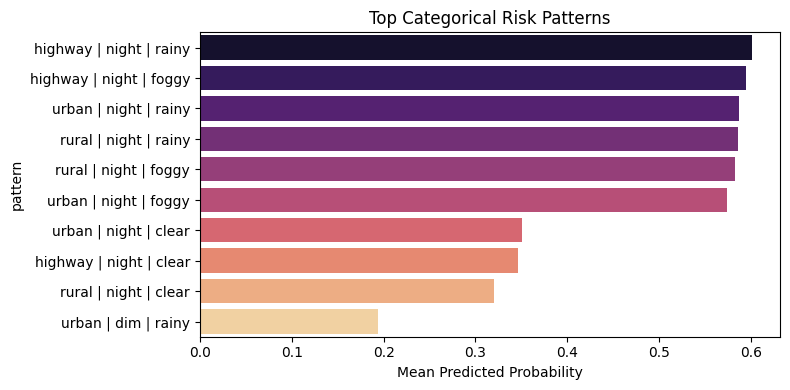

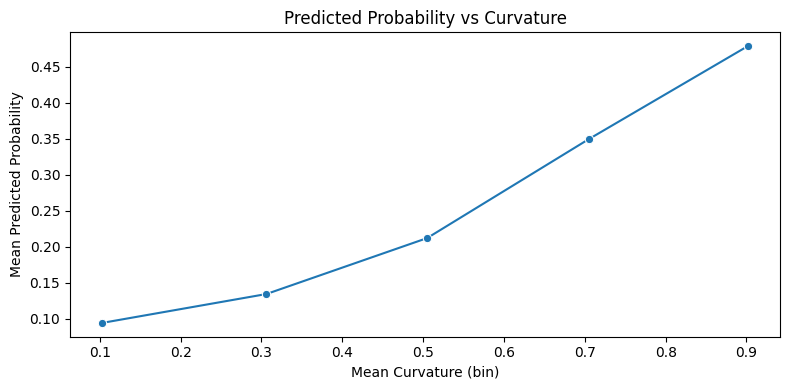

In [ ]:
# Risk pattern analysis: group-level summaries, bins, interactions, and top segments
analysis = analysis_df.copy()

# Decode categorical labels (uses existing label_encoders and cat_cols)
for col in cat_cols:
    if col in analysis.columns and col in label_encoders:
        analysis[f'{col}_label'] = label_encoders[col].inverse_transform(analysis[col].astype(int))

# Create numeric bins
analysis['curv_bin'] = pd.cut(analysis['curvature'], bins=np.linspace(analysis['curvature'].min(), analysis['curvature'].max(), 6))
analysis['speed_bin'] = pd.cut(analysis['speed_limit'], bins=[0,30,45,55,65,75,200])
analysis['reports_bin'] = pd.cut(analysis['num_reported_accidents'], bins=[-1,0,1,2,3,5,999])

# Top categorical pattern combos (use first 3 categorical labels available)
group_cols = [f'{c}_label' for c in cat_cols if f'{c}_label' in analysis.columns]
group_cols_top = group_cols[:3]
patterns = (analysis.groupby(group_cols_top)
            .agg(mean_pred_prob=('predicted_prob','mean'),
                 mean_actual=('actual_risk','mean'),
                 count=('predicted_prob','size'))
            .reset_index())
patterns['pattern'] = patterns[group_cols_top].astype(str).agg(' | '.join, axis=1)
patterns['lift'] = patterns['mean_pred_prob'] / analysis['predicted_prob'].mean()
top_patterns = patterns[patterns['count']>=50].sort_values('mean_pred_prob', ascending=False).head(10)

# Numeric bin summaries
curv_stats = (analysis.groupby('curv_bin')
              .agg(mean_curvature=('curvature','mean'),
                   mean_pred_prob=('predicted_prob','mean'),
                   mean_actual=('actual_risk','mean'),
                   count=('predicted_prob','size'))
              .reset_index())

# Simulate only high-risk segment summary (predicted_prob >= 0.8)
high_risk = analysis[analysis['predicted_prob'] >= 0.8]
high_risk_summary = (high_risk.groupby(group_cols_top)
                     .agg(mean_pred_prob=('predicted_prob','mean'),
                          mean_actual=('actual_risk','mean'),
                          count=('predicted_prob','size'))
                     .reset_index()
                     .sort_values('mean_pred_prob', ascending=False))

reports_stats = (analysis.groupby('reports_bin')
                 .agg(mean_reports=('num_reported_accidents','mean'),
                      mean_pred_prob=('predicted_prob','mean'),
                      mean_actual=('actual_risk','mean'),
                      count=('predicted_prob','size'))
                 .reset_index())

# Interaction: speed_bin x curv_bin average predicted probability
pivot_speed_curv = analysis.pivot_table(index='speed_bin', columns='curv_bin', values='predicted_prob', aggfunc='mean')

# High-risk segments (predicted_prob >= 0.8)
high_risk = analysis[analysis['predicted_prob'] >= 0.8]
high_risk_summary = (high_risk.groupby(group_cols_top)
                     .agg(mean_pred_prob=('predicted_prob','mean'),
                          mean_actual=('actual_risk','mean'),
                          count=('predicted_prob','size'))
                     .reset_index()
                     .sort_values('mean_pred_prob', ascending=False))

# Display concise results
print("Top categorical patterns (by predicted prob):")
display(top_patterns[['pattern','mean_pred_prob','mean_actual','count','lift']])

print("\nCurvature bin stats:")
display(curv_stats)

print("\nSpeed bin stats:")
display(speed_stats)

print("\nReported-accidents bin stats:")
display(reports_stats)

print("\nPivot: speed_bin x curv_bin (mean predicted_prob):")
display(pivot_speed_curv)

print("\nHigh-risk segment summary (predicted_prob >= 0.8):")
display(high_risk_summary.head(10))

# Simple visualizations
plt.figure(figsize=(8,4))
sns.barplot(data=top_patterns, x='mean_pred_prob', y='pattern', palette='magma')
plt.xlabel('Mean Predicted Probability')
plt.title('Top Categorical Risk Patterns')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.lineplot(data=curv_stats, x='mean_curvature', y='mean_pred_prob', marker='o')
plt.xlabel('Mean Curvature (bin)')
plt.ylabel('Mean Predicted Probability')
plt.title('Predicted Probability vs Curvature')
plt.tight_layout()
plt.show()